# Rare Occupation Classification

This example notebook uses hypothetical data to show how the `BinaryContextTransformer` could be used to help classify occupation codes.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from binarycontexttransformer import BinaryContextTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

These helper functions will provide visualizations of the data, predictions, and model weights.

In [2]:
def show_preds(df, X, y, clf, occupations, duplicates=False):
    df = df.copy()
    df["pred"] = [occupations[code] for code in clf.predict(X)]
    df["proba"] = clf.predict_proba(X).max(axis=1)
    df["correct"] = df["pred"] == df["occupation"]
    if not duplicates:
        df = df.drop_duplicates()
    acc = accuracy_score(df["occupation"], df["pred"])
    pred_df = df[["correct", "occupation", "pred", "proba", "jobtitle", "industry"]]
    out = pred_df.style.apply(lambda row: [
        "background: mediumspringgreen;" if row["pred"] is row["occupation"] else "background: tomato;" for cell in row
    ], axis=1, subset=["occupation", "pred"])
    print("Accuracy = {:.3f}".format(acc))
    return out


def show_weights(clf, features, occupations, ax=None):
    has_plot = True
    if ax is None:
        _, ax = plt.subplots(1, 1)
        has_plot = False
    weights = np.hstack([clf.intercept_.reshape(-1, 1), clf.coef_]).T
    classes = [occupations[code] for code in clf.classes_]
    predictors = ["intercept"] + features
    class_labels = ["\n".join(c.split(" ")) for c in classes]
    sns.heatmap(weights, annot=True, fmt=".3f", cmap="RdBu", ax=ax)
    ax.set_xticks(np.arange(len(classes)) + 0.5)
    ax.set_yticks(np.arange(len(predictors)) + 0.5)
    ax.set_xticklabels(class_labels, {"rotation": 0})
    ax.set_yticklabels(predictors, {"rotation": 0})
    ax.set_xlabel("Target Class")
    ax.set_ylabel("Predictor Variable")
    ax.set_title("Model Weights")
    if not has_plot:
        plt.show()

    
def show_matrix(X, labels, features, occupations, duplicates=False):
    out = pd.DataFrame(X.todense(), columns=features, index=labels)
    if not duplicates:
        out = out.drop_duplicates()
        return out

In [3]:
fields = ["occupation", "code", "jobtitle", "industry"]

occupations = {
    "27-3021": "Broadcast News Analysts",
    "13-2051": "Financial Analysts",
    "15-1121": "Computer Systems Analysts",
    "13-2011": "Accountants and Auditors",
    "15-1132": "Software Developers, Applications",
    "27-3022": "Reporters and Correspondents"
}

data = [
    ("13-2051", "financial analyst", "finance"),
    ("13-2051", "financial analyst", "finance"),
    ("27-3021", "news analyst", "news"),
    ("27-3021", "news analyst", "news"),
    ("15-1121", "computer analyst", "tech"),
    ("15-1121", "computer analyst", "tech"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("13-2011", "accountant", "finance"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("27-3022", "reporter", "news"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
    ("15-1132", "developer", "tech"),
]

data_validate = [
    ("15-1121", "analyst", "tech"),
    ("27-3021", "analyst", "news"),
    ("13-2051", "analyst", "finance"),
]

For this hypothetical example, the task is to predict what kind of occupation a job falls under, based on the job title and the industry.

In this hypothetical universe, let us assume that there are only six different occupations and only three different industries. In each industry, there are two occupations: one that occurs more frequently in the training data and one that occurs relatively less frequently.

The table shows the six distinct job titles, the corresponding occupation classifications, and the frequencies in the training data.

In [4]:
df = pd.DataFrame(data, columns=["code", "jobtitle", "industry"])
df["occupation"] = df["code"].apply(lambda code: occupations[code])
pd.DataFrame(df.groupby(fields).size().reset_index().values, columns=fields + ["count"])

,occupation,code,jobtitle,industry,count
0,Accountants and Auditors,13-2011,accountant,finance,7
1,Broadcast News Analysts,27-3021,news analyst,news,2
2,Computer Systems Analysts,15-1121,computer analyst,tech,2
3,Financial Analysts,13-2051,financial analyst,finance,2
4,Reporters and Correspondents,27-3022,reporter,news,7
5,"Software Developers, Applications",15-1132,developer,tech,7


Suppose that the validation data, which is not used to train a model, contains job titles that are less informative compared to the training data. In the data below, every record has the job title `"analyst"`, but each is a different kind of occupation. Using information about the industry, a human should be able to figure out which kind of analyst is the correct match.

_**Note:** It might be more reasonable to assume that some data like this will be part of the training dataset. However, in large datasets, if these low-information titles are infrequent in the training data, a model might not learn appropriate weights for each word. Or, if the low-information titles are very frequent in the training data, a model might learn the wrong associations between words and occupations._

In [5]:
df_validate = pd.DataFrame(data_validate, columns=["code", "jobtitle", "industry"])
df_validate["occupation"] = df_validate["code"].apply(lambda code: occupations[code])
df_validate[fields]

,occupation,code,jobtitle,industry
0,Computer Systems Analysts,15-1121,analyst,tech
1,Broadcast News Analysts,27-3021,analyst,news
2,Financial Analysts,13-2051,analyst,finance


## 1. Basic Model

Let us try to train a logistic regression model (with L2 penalty) to predict the occupation code. This model uses binary variables for each job title word and each industry as predictors.

In [6]:
jobtitle_vectorizer = CountVectorizer(analyzer="word", binary=True)
industry_vectorizer = CountVectorizer(analyzer="word", binary=True)
X_jobtitle = jobtitle_vectorizer.fit_transform(df["jobtitle"])
X_industry = industry_vectorizer.fit_transform(df["industry"])
X_basic = sp.sparse.hstack([X_jobtitle, X_industry])
y = df["code"]

features_jobtitle = ["job_" + f for f in jobtitle_vectorizer.get_feature_names()]
features_industry = ["ind_" + f for f in industry_vectorizer.get_feature_names()]
features_basic = features_jobtitle + features_industry

clf_basic = LogisticRegression(solver="lbfgs", multi_class="multinomial", fit_intercept=True, penalty="l2")
clf_basic.fit(X_basic, y)
y_basic = clf_basic.predict(X_basic)

### 1.1. Basic Model Matrix

This table shows how each of the six distinct job titles in our training data gets represented in the input data. There are 10 total features, 7 from job title words and 3 from industries.

In [7]:
print("{} features in `term` matrix".format(X_basic.shape[1]))
print("{} features from `jobtitle`".format(X_jobtitle.shape[1]))
print("{} features from `industry`".format(X_industry.shape[1]))
show_matrix(X_basic, df["jobtitle"].values, features_basic, occupations)

10 features in `term` matrix
7 features from `jobtitle`
3 features from `industry`


,job_accountant,job_analyst,job_computer,job_developer,job_financial,job_news,job_reporter,ind_finance,ind_news,ind_tech
financial analyst,0,1,0,0,1,0,0,1,0,0
news analyst,0,1,0,0,0,1,0,0,1,0
computer analyst,0,1,1,0,0,0,0,0,0,1
accountant,1,0,0,0,0,0,0,1,0,0
reporter,0,0,0,0,0,0,1,0,1,0
developer,0,0,0,1,0,0,0,0,0,1


### 1.2. Basic Model Predictions

With this model, we can achieve 100% accuracy on the training dataset! Hooray!

In [8]:
show_preds(df, X_basic, y, clf_basic, occupations)

Accuracy = 1.000


,correct,occupation,pred,proba,jobtitle,industry
0,True,Financial Analysts,Financial Analysts,0.545106,financial analyst,finance
2,True,Broadcast News Analysts,Broadcast News Analysts,0.545106,news analyst,news
4,True,Computer Systems Analysts,Computer Systems Analysts,0.545106,computer analyst,tech
6,True,Accountants and Auditors,Accountants and Auditors,0.822282,accountant,finance
13,True,Reporters and Correspondents,Reporters and Correspondents,0.822282,reporter,news
20,True,"Software Developers, Applications","Software Developers, Applications",0.822282,developer,tech


However, on the validation dataset, the accuracy is 0%...

In [9]:
X_jobtitle_validate = jobtitle_vectorizer.transform(df_validate["jobtitle"])
X_industry_validate = industry_vectorizer.transform(df_validate["industry"])
X_basic_validate = sp.sparse.hstack([
    X_jobtitle_validate,
    X_industry_validate,
])
show_preds(df_validate, X_basic_validate, y, clf_basic, occupations)

Accuracy = 0.000


,correct,occupation,pred,proba,jobtitle,industry
0,False,Computer Systems Analysts,"Software Developers, Applications",0.325774,analyst,tech
1,False,Broadcast News Analysts,Reporters and Correspondents,0.325774,analyst,news
2,False,Financial Analysts,Accountants and Auditors,0.325774,analyst,finance


Notice that when the model misclassifies each analyst, it does not predict a different kind of analyst. In fact, it predicts a different kind of occupation altogether. This seems strange.

1. Why does the model classify the job as a different occupation, instead of a different kind of analyst?
2. Why does the model fail to distinguish different types of analysts when it has industry as a predictor variable?

The answer involves the multiclass nature of the task and imbalances in the frequencies of the occupations.

- The word `"analyst"` is not predictive in this case because in the training data that word appears in three different occupations at the same frequency in each occupation. Each of the three analyst occupations is equally likely.
- The model learns a weight between each industry and each occupation. The larger weights correspond to the occupations that are more frequent in that industry.

Thus, the model ends up predicting the occupation that is most common in the given industry, rather than a different kind of analyst.

### 1.3. Basic Model Weights

To understand this outcome, it may be helpful to inspect the weights of the logistic regression model. Each row in the grid below represents a predictor variable and each column represents an occupation.

Take for example an analyst working in the news industry. The model misclassifies their occupation as `"Reporters and Correspondents"` when they should fall under `"Broadcast News Analysts"`.

As expected, the highest coefficients for the word `"analyst"` are in the three analyst occupations. These coefficients and the intercepts are all equal. This means that a prediction based only on the word `"analyst"` would given equal predicted probabilities for each of those three occupations.

The industry variable breaks the tie. Since the record is in the news industry, only two weights activate in the industry section of this grid. The news industry coefficient weight for `"Reporters and Correspondents"` is higher than the weight for `"Broadcast News Analysts"`, so the former is the prediction output.

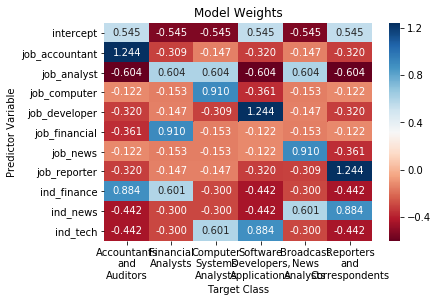

In [10]:
show_weights(clf_basic, features_basic, occupations)

## 2. Context Model

The `BinaryContextTransformer` may be useful in creating a more detailed representation of the input data: allowing us to learn different weights for each job title word, based on the industry it appears in. We will observe how this changes the model weights and the predictions.

In [11]:
help(BinaryContextTransformer)

Help on class BinaryContextTransformer in module binarycontexttransformer:

class BinaryContextTransformer(sklearn.base.TransformerMixin)
 |  Expands base features into interaction terms when they appear with
 |  different context features. Base features are variables that may have different
 |  meanings in different contexts. Context features are indicator variables that
 |  denote which context a record belongs to. Both base features and context features
 |  must be binary.
 |  
 |  Method resolution order:
 |      BinaryContextTransformer
 |      sklearn.base.TransformerMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, features, contexts, progress=None)
 |      Args:
 |          features: names of base feature columns for input matrix
 |          contexts: names of context feature columns for input matrix
 |          progress: function of format progress_fn(iter, total) that takes
 |              an iterable and an integer with the total number of 

The `BinaryContextTransformer` takes the matrices produced by the `CountVectorizer` transformers as input. The job title words are the **base** features and the industries are the **context** features. Each record is part of only one industry. We stack the two input matrices from the `CountVectorizer` transformers and the matrix output by the `BinaryContextTransformer` and use this as the input to our new model.

In [12]:
bct = BinaryContextTransformer(
    features=features_jobtitle,
    contexts=features_industry
)
X_jobtitle_industry = bct.fit_transform(X_jobtitle, X_industry)
X_context = sp.sparse.hstack([X_jobtitle, X_industry, X_jobtitle_industry])
features_context = features_basic + bct.get_feature_names()

clf_context = LogisticRegression(solver="lbfgs", multi_class="multinomial", fit_intercept=True, penalty="l2")
clf_context.fit(X_context, y)
y_context = clf_context.predict(X_context)

### 2.1. Context Model Matrix

For an alternative model, we still use a logistic regression (with L2 penalty). This time, we add the binary context terms for interactions between job title words and industry. Now there are 13 total features.

Notice that we only added binary context features for job title words that appear in at least two different industries. The only word that appears in multiple industries is `"analyst"` and it appears in all three industries.

In [13]:
print("{} features in `context` matrix".format(X_context.shape[1]))
print("{} features from `jobtitle`".format(X_jobtitle.shape[1]))
print("{} features from `industry`".format(X_industry.shape[1]))
print("{} features from `jobtitle_x_industry`".format(X_jobtitle_industry.shape[1]))
show_matrix(X_context, df["jobtitle"].values, features_context, occupations)

13 features in `context` matrix
7 features from `jobtitle`
3 features from `industry`
3 features from `jobtitle_x_industry`


,job_accountant,job_analyst,job_computer,job_developer,job_financial,job_news,job_reporter,ind_finance,ind_news,ind_tech,ind_finance_x_job_analyst,ind_news_x_job_analyst,ind_tech_x_job_analyst
financial analyst,0,1,0,0,1,0,0,1,0,0,1,0,0
news analyst,0,1,0,0,0,1,0,0,1,0,0,1,0
computer analyst,0,1,1,0,0,0,0,0,0,1,0,0,1
accountant,1,0,0,0,0,0,0,1,0,0,0,0,0
reporter,0,0,0,0,0,0,1,0,1,0,0,0,0
developer,0,0,0,1,0,0,0,0,0,1,0,0,0


### 2.2. Context Model Predictions

Just as with the basic model, our context model achieves 100% accuracy on the training set.

In [14]:
show_preds(df, X_context, y, clf_context, occupations)

Accuracy = 1.000


,correct,occupation,pred,proba,jobtitle,industry
0,True,Financial Analysts,Financial Analysts,0.628344,financial analyst,finance
2,True,Broadcast News Analysts,Broadcast News Analysts,0.628344,news analyst,news
4,True,Computer Systems Analysts,Computer Systems Analysts,0.628344,computer analyst,tech
6,True,Accountants and Auditors,Accountants and Auditors,0.830019,accountant,finance
13,True,Reporters and Correspondents,Reporters and Correspondents,0.830019,reporter,news
20,True,"Software Developers, Applications","Software Developers, Applications",0.830019,developer,tech


This time, the context model also achieves 100% accuracy on the validation set!

In [15]:
X_jobtitle_validate = jobtitle_vectorizer.transform(df_validate["jobtitle"])
X_industry_validate = industry_vectorizer.transform(df_validate["industry"])
X_context_validate = sp.sparse.hstack([
    X_jobtitle_validate,
    X_industry_validate,
    bct.transform(X_jobtitle_validate, X_industry_validate)
])
show_preds(df_validate, X_context_validate, y, clf_context, occupations)

Accuracy = 1.000


,correct,occupation,pred,proba,jobtitle,industry
0,True,Computer Systems Analysts,Computer Systems Analysts,0.399234,analyst,tech
1,True,Broadcast News Analysts,Broadcast News Analysts,0.399234,analyst,news
2,True,Financial Analysts,Financial Analysts,0.399234,analyst,finance


What happened? Could this be model overfitting?

### 2.3. Context Model Weights

Just as in the basic model, the coefficients for the word `"analyst"` and the three analyst occupations have equal values. The industry coefficients have higher values for the more frequent occupation in their industry.

Now, there are additional coefficients for the binary context features. These coefficients have higher values for the binary context features between each industry and the word `"analyst"`, which pushes the prediction output to the correct answer.

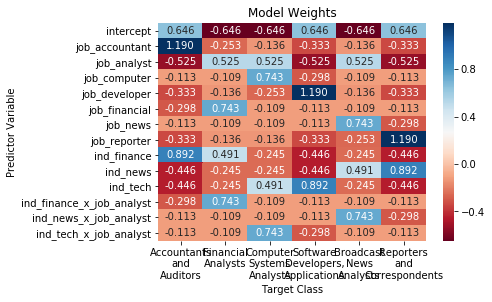

In [16]:
show_weights(clf_context, features_context, occupations)

### 2.4 Comparison of Model Weights

Comparing the model coefficients side-by-side shows that the context model has more weights. Adding extra predictors can sometimes lead to overfitting. Even with L2 penalty, the weights for the binary context features end up having higher values than the other weights in their column so that they can override the effect of the industry features.

Does this lead to overfitting? Certainly, the context model is more complex than the basic model. Using binary context features could lead to a higher variance model by enabling spurious associations or by making the model more sensitive to certain combinations of industries and job title words.

However, the term "overfitting" may not be appropriate here because neither model is trained on data where the job title contains only the word `"analyst"`. Since those low-information job titles are used to evaluate the model, they still influence the model selection process. If we compare the models based on some out-of-sample validation set, we assume that future data will look like that data, both in content and distribution.

In this hypothetical example, we expect that the word `"analyst"` should be treated differently based on the industry. Since the context model accomplishes that, it offers a richer representation for this task.

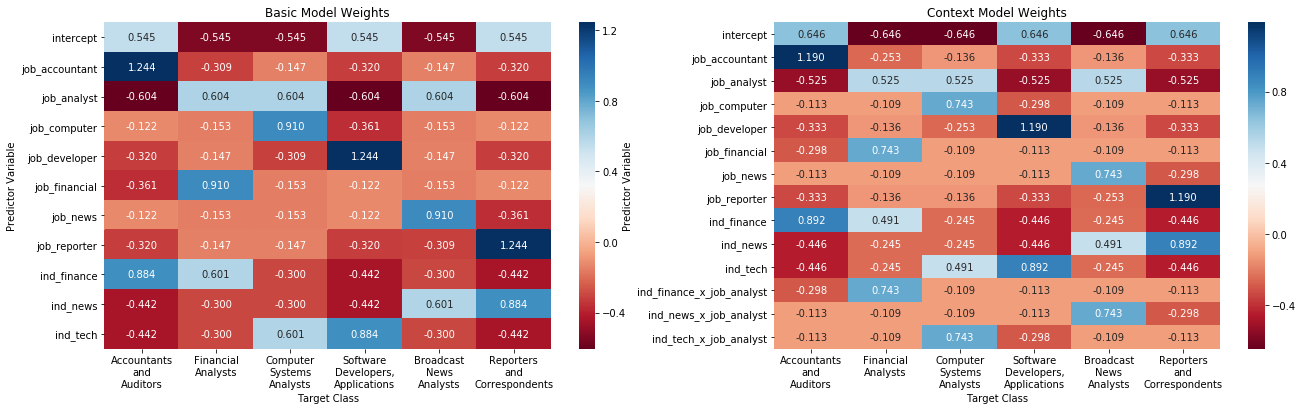

In [17]:
fig, axes = plt.subplots(1, 2)
show_weights(clf_basic, features_basic, occupations, ax=axes[0])
show_weights(clf_context, features_context, occupations, ax=axes[1])
axes[0].set_title("Basic Model Weights")
axes[1].set_title("Context Model Weights")
fig.set_size_inches((22, 6))
plt.show()

This hypothetical example shows a small training set and a small vocabulary. The `BinaryContextTransformer` can be useful if you need to efficiently generate contextual features for large datasets. A large dataset also offers a greater chance of generating unnecessary combinations. To determine if `BinaryContextTransformer` is appropriate for your task:

- Check that there is a task or domain-related justification for binary context features
- Use appropriate data cleaning and feature selection methods before applying this transformation